# Preparing the environment

In [1]:
packrat::init("/work/postresearch/Shared/Projects/Farbod/CaseMix")
packrat::on()
#packrat::status()

Initializing packrat project in directory:
- "/work/postresearch/Shared/Projects/Farbod/CaseMix"

Initialization complete!



In [2]:
#install.packages(c("httr", "jsonlite"))

In [3]:
library(httr)
library(jsonlite)
library(data.table)
library(dtplyr)

# Importing the CMS data

In [4]:
cms_data_importer=function(url,data_size){

  require(data.table)
  require(dplyr)
  require(httr)
  require(jsonlite)
  require(tidyverse)
  
  stats=GET(paste(url,"/stats",sep = ""))

  row_count=content(stats,as="parsed")$total_rows

  offset=0
  data=data.table()

  if(data_size=="all"){
    while(offset<row_count){
      new_get=GET(paste(url,"?size=5000&offset=",offset,sep = ""))
      new_data=fromJSON(rawToChar(new_get$content))
      data=rbind(data,new_data)
      offset=offset+5000
    }
  }
  else{
    while(offset<data_size){
      new_get=GET(paste(url,"?size=5000&offset=",offset,sep = ""))
      new_data=fromJSON(rawToChar(new_get$content))
      data=rbind(data,new_data)
      offset=offset+5000
    }
  }
  
  return(data%>%as.data.table())

}

In [5]:
physician_data=cms_data_importer(
  url = 
  "https://data.cms.gov/data-api/v1/dataset/14cd68c2-9433-4069-90fa-d213ef709661/data",
  data_size=100000
)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [6]:
colnames(physician_data)

[1] "Rndrng_NPI"                    "Rndrng_Prvdr_Last_Org_Name"   
 [3] "Rndrng_Prvdr_First_Name"       "Rndrng_Prvdr_MI"              
 [5] "Rndrng_Prvdr_Crdntls"          "Rndrng_Prvdr_Gndr"            
 [7] "Rndrng_Prvdr_Ent_Cd"           "Rndrng_Prvdr_St1"             
 [9] "Rndrng_Prvdr_St2"              "Rndrng_Prvdr_City"            
[11] "Rndrng_Prvdr_State_Abrvtn"     "Rndrng_Prvdr_State_FIPS"      
[13] "Rndrng_Prvdr_Zip5"             "Rndrng_Prvdr_RUCA"            
[15] "Rndrng_Prvdr_RUCA_Desc"        "Rndrng_Prvdr_Cntry"           
[17] "Rndrng_Prvdr_Type"             "Rndrng_Prvdr_Mdcr_Prtcptg_Ind"
[19] "HCPCS_Cd"                      "HCPCS_Desc"                   
[21] "HCPCS_Drug_Ind"                "Place_Of_Srvc"                
[23] "Tot_Benes"                     "Tot_Srvcs"                    
[25] "Tot_Bene_Day_Srvcs"            "Avg_Sbmtd_Chrg"               
[27] "Avg_Mdcr_Alowd_Amt"            "Avg_Mdcr_Pymt_Amt"            
[29] "Avg_Mdcr_Stdzd_Amt"

In [7]:
physician_data=physician_data[,.(Rndrng_NPI,Rndrng_Prvdr_Type,HCPCS_Cd,Tot_Srvcs)]

In [8]:
head(physician_data, 10)
dim(physician_data)

Rndrng_NPI,Rndrng_Prvdr_Type,HCPCS_Cd,Tot_Srvcs
<chr>,<chr>,<chr>,<chr>
1003000126,Internal Medicine,99217,23
1003000126,Internal Medicine,99218,16
1003000126,Internal Medicine,99220,16
1003000126,Internal Medicine,99221,12
1003000126,Internal Medicine,99223,52
1003000126,Internal Medicine,99232,134
1003000126,Internal Medicine,99233,326
1003000126,Internal Medicine,99238,13
1003000126,Internal Medicine,99239,146


[1] 100000      4

In [9]:
physician_data[,Tot_Srvcs:=as.numeric(Tot_Srvcs)]

# Converting the data to wide format

In [10]:
physician_data_wide=dcast(physician_data, Rndrng_NPI+Rndrng_Prvdr_Type ~ HCPCS_Cd,
 value.var = 'Tot_Srvcs', fun.aggregate = sum )%>%
 data.frame()%>%
 data.table()


In [11]:
head(physician_data_wide)
dim(physician_data_wide)

Rndrng_NPI,Rndrng_Prvdr_Type,X0001A,X0011A,X0042T,X0054T,X0055T,X0097U,X0191T,X0202U,⋯,Q9965,Q9966,Q9967,Q9969,R0070,R0075,U0002,U0003,U0004,V2785
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003000126,Internal Medicine,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000142,Anesthesiology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000423,Obstetrics & Gynecology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000480,General Surgery,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000522,Family Practice,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11657  2429

# Sparcity reducer function

In [12]:
sparsity_reducer=function(data,prp=0.2){
  
  sparse_columns=
  colMeans(data[,-c(1,2)]>0)%>%
  as.data.table(keep.rownames = T)%>%
  set_names(c("names","means"))%>%
  arrange(-means)%>%
  slice_head(prop=prp)%>%
  as.data.table()
  
  cbind(data[,c(1,2)],data[,sparse_columns$names,with=F])
  
}


In [92]:
physician_data_wide_reduced=sparsity_reducer(physician_data_wide,prp = 0.1)
head(physician_data_wide_reduced)

Rndrng_NPI,Rndrng_Prvdr_Type,X99213,X99214,X99232,X99204,X99203,G0008,X99233,X99223,⋯,X90960,X90961,Q0091,X99316,G0279,X11104,X73221,X73700,X93280,X93458
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003000126,Internal Medicine,0,0,134,0,0,0,326,52,⋯,0,0,0,0,0,0,0,0,0,0
1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000142,Anesthesiology,304,148,0,44,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000423,Obstetrics & Gynecology,14,0,0,0,0,0,0,0,⋯,0,0,15,0,0,0,0,0,0,0
1003000480,General Surgery,20,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000522,Family Practice,112,162,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [18]:
physician_data_wide[Rndrng_NPI==1003000126,"X99232"]

X99232
<dbl>
134


# Euclidean distance finder

In [19]:
distance_finder=function(x,y){
  sqrt(sum((x-y)^2, na.rm = T))
}

In [20]:
x=c(1,2,3,4,5)
y=c(2,3,4,5,6)
distance_finder(x,y)

[1] 2.236068

In [21]:
2.23606797749979^2

[1] 5

# Creating test and train sets

In [22]:
#install.packages("caTools")

In [69]:
library(caTools)
set.seed=123
sample=sample.split(SplitRatio = 0.8 , physician_data_wide_reduced$Rndrng_NPI)
test_set=subset(physician_data_wide_reduced,sample==F)%>%as.data.frame()
training_set=subset(physician_data_wide_reduced,sample==T)%>%as.data.frame()

In [70]:
head(training_set)
dim(training_set)

,Rndrng_NPI,Rndrng_Prvdr_Type,X0001A,X0011A,X0042T,X0054T,X0055T,X0097U,X0191T,X0202U,⋯,Q9965,Q9966,Q9967,Q9969,R0070,R0075,U0002,U0003,U0004,V2785
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1003000126,Internal Medicine,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1003000142,Anesthesiology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1003000423,Obstetrics & Gynecology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1003000480,General Surgery,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1003000522,Family Practice,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 9325 2429

# The KNN function

In [71]:
#install.packages(c("foreach","doMC"))

In [72]:
knn=function(k=1,train_data,test_data,name_var,outcome_var,mode="prediction",ncores=2,sparsity_prp=1,scale=T){
  
  require(data.table)
  require(dtplyr)
  require(tidyverse)
  library(foreach)
  library(doMC)
  registerDoMC(cores=ncores)

  distance_finder=function(x,y){
    sqrt(sum((x-y)^2,na.rm = T))
  }
  
  sparsity_reducer=function(data,prp){
  
  sparse_columns=
  colMeans(data[,!names(data) %in% c(name_var,outcome_var)])%>%
  as.data.table(keep.rownames = T)%>%
  set_names(c("names","means"))%>%
  arrange(-means)%>%
  slice_head(prop=prp)%>%
  as.data.table()
  
  cbind(data[,c(name_var,outcome_var)],data[,sparse_columns$names])
  }
  
  test_data=
  sparsity_reducer(test_data,
                   prp = sparsity_prp)
  
  train_data=train_data[,colnames(test_data)]
  
  if(scale==T){
    test_data[,!names(test_data) %in% c(name_var,outcome_var)]=lapply(test_data[,!names(test_data) %in% c(name_var,outcome_var)],scale)
    train_data[,!names(train_data) %in% c(name_var,outcome_var)]=lapply(train_data[,!names(train_data) %in% c(name_var,outcome_var)],scale)
  }
    
    result=
    foreach(a = 1:nrow(test_data), .combine=rbind) %:%
      foreach(b = 1:nrow(train_data) , .combine=rbind) %dopar% {
        data.frame(distance_finder(test_data[a,!names(test_data) %in% c(name_var,outcome_var)],
                        train_data[b,!names(train_data) %in% c(name_var,outcome_var)]),
          train_data[b,c(name_var,outcome_var)],
          test_data[a,c(name_var,outcome_var)])
      }


  colnames(result)=
  c("Distance",
    paste("training",name_var,sep="_"),
    paste("training",outcome_var,sep="_"),
    paste("test",name_var,sep="_"),
    paste("test",outcome_var,sep="_"))

  result=result%>%
  group_by(eval(parse(text=paste("test",outcome_var,sep="_"))))%>%
  arrange(Distance,.by_group = T)%>%
  as.data.table()

  Mode = function(x) {
    uniques = unique(x)
    uniques[which.max(tabulate(match(x, uniques)))]
    }

  prediction=result[,prediction:= Mode(head(eval(parse(text=paste("training",outcome_var,sep="_"))),k))
                    ,by=eval(parse(text=paste("test",name_var,sep="_")))]

  
  result=result[,head(.SD,k),by=eval(parse(text=paste("test",name_var,sep="_")))]
  
  colnames(result)[1]="test_ID"
  colnames(result)[5]="expected"
  
  result=result[,-6]
  
  if(mode=="diagnosis"){
    result=result
  }
  if(mode=="prediction"){
    result=result[,head(.SD,1),keyby=test_ID]
    result=result[,.(test_ID,expected,prediction)]
    result=result[,correct_prediction:=(expected==prediction)]
  }


  return(result)

}

## Trying the function on the CMS data

In [102]:
knn_results=
knn(
  k=sqrt(length(training_set)),
  train_data=training_set,
  test_data = test_set[1:100,],
  ncores = 80,
  outcome_var = "Rndrng_Prvdr_Type",
  name_var = "Rndrng_NPI",
  mode="prediction",
  sparsity_prp=1,
  scale=T
)

In [106]:
head(knn_results,10)

test_ID,expected,prediction,correct_prediction
<chr>,<chr>,<chr>,<lgl>
1003000530,Internal Medicine,Family Practice,FALSE
1003000704,Anesthesiology,Certified Registered Nurse Anesthetist (CRNA),FALSE
1003000829,Physical Therapist in Private Practice,Physical Therapist in Private Practice,TRUE
1003001140,Physical Therapist in Private Practice,Physical Therapist in Private Practice,TRUE
1003001785,Orthopedic Surgery,Orthopedic Surgery,TRUE
1003001918,Physical Therapist in Private Practice,Physical Therapist in Private Practice,TRUE
1003002072,Urology,Physician Assistant,FALSE
1003002379,Internal Medicine,Physician Assistant,FALSE
1003002643,Physician Assistant,Family Practice,FALSE


In [107]:
mean(knn_results$correct_prediction)

[1] 0.5

# Comparing to the Random Forest

In [89]:
library(randomForest)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




In [98]:
rf_phys=randomForest(y=as.factor(training_set$Rndrng_Prvdr_Type), x= training_set[,!names(training_set) %in% c("Rndrng_NPI","Rndrng_Prvdr_Type")],ntree = 500)

In [99]:
predictions=predict(rf_phys,test_set[1:100,])
predictions=data.frame(prediction=predictions,expected=test_set[1:100,c("Rndrng_Prvdr_Type")])%>%as.data.table()
predictions=predictions[,correct_prediction:=(expected==prediction)]

In [100]:
mean(predictions$correct_prediction)

[1] 0.49

# Timing the function with different data sizes

In [108]:
library(caTools)
set.seed=123
sample=sample.split(SplitRatio = 0.8 , physician_data_wide$Rndrng_NPI)
test_set=subset(physician_data_wide,sample==F)%>%as.data.frame()
training_set=subset(physician_data_wide,sample==T)%>%as.data.frame()

In [109]:
head(training_set)
dim(training_set)

,Rndrng_NPI,Rndrng_Prvdr_Type,X0001A,X0011A,X0042T,X0054T,X0055T,X0097U,X0191T,X0202U,⋯,Q9965,Q9966,Q9967,Q9969,R0070,R0075,U0002,U0003,U0004,V2785
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1003000126,Internal Medicine,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1003000142,Anesthesiology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1003000423,Obstetrics & Gynecology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1003000480,General Surgery,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1003000522,Family Practice,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 9325 2429

In [112]:
times=data.frame()
for (x in seq(5,35,5)){
  times=rbind(times,
  system.time(
    knn(k=x,
        train_data=training_set[1:(x^2),],
        test_data = test_set[1:((x^2)/5),],
        ncores = 56,
        outcome_var = "Rndrng_Prvdr_Type",
        name_var = "Rndrng_NPI",
        mode="prediction",
        sparsity_prp=(x^2)/2000,
        scale=T
     )))
}

In [113]:
times

X0.6099999999999,X3.297,X3.60399999999936,X0.152999999991152,X2.84899999999834
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.610,3.297,3.604,0.153,2.849
0.692,3.100,4.224,26.131,25.600
2.802,3.291,12.665,317.304,36.330
8.723,3.384,48.135,1904.047,109.290
20.534,3.789,177.667,8017.400,248.035
35.280,4.620,548.806,26579.159,296.491
62.147,5.636,1434.276,69994.053,1032.122


In [121]:
time_seq=seq(5,35,5)^2

Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


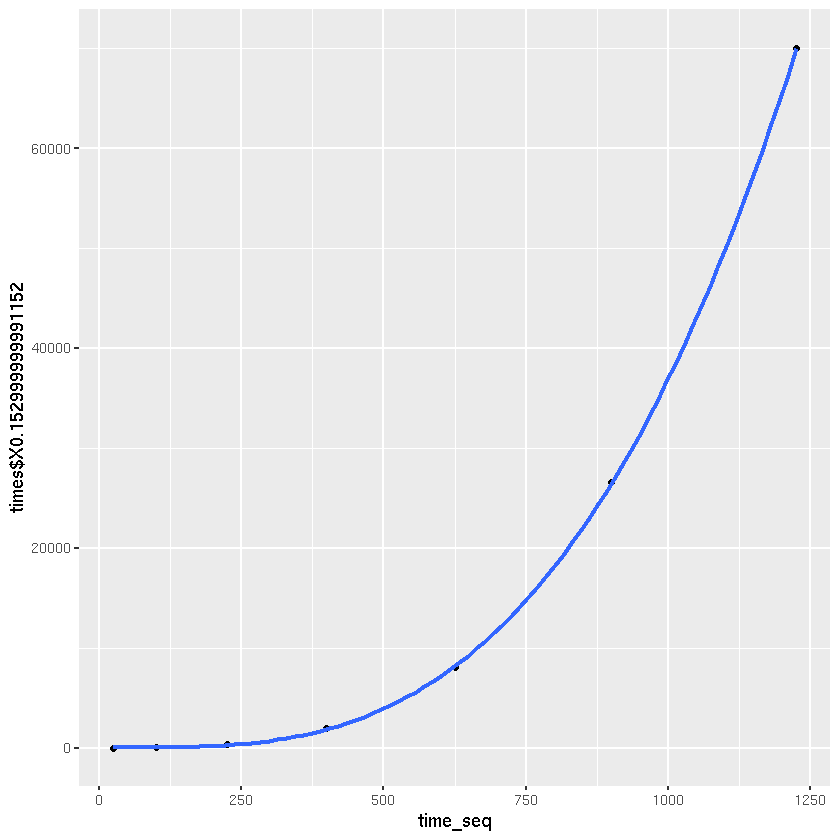

In [124]:
ggplot()+
geom_point(aes(x=time_seq,y=times$X0.152999999991152))+
geom_smooth(method="lm",aes(x=time_seq,y=times$X0.152999999991152),formula = y~poly(x,3))

In [125]:
predictor_time=lm(times$X0.152999999991152~poly(time_seq,3))
summary(predictor_time)


Call:
lm(formula = times$X0.152999999991152 ~ poly(time_seq, 3))

Residuals:
       1        2        3        4        5        6        7 
 -30.106   -7.775   66.107   51.626 -165.511  109.175  -23.516 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        15262.61      47.74  319.68 6.75e-08 ***
poly(time_seq, 3)1 57342.23     126.32  453.95 2.36e-08 ***
poly(time_seq, 3)2 27052.83     126.32  214.17 2.24e-07 ***
poly(time_seq, 3)3  4791.58     126.32   37.93 4.03e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 126.3 on 3 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 8.446e+04 on 3 and 3 DF,  p-value: 6.916e-08


## Without sparsity reduction

In [486]:
times_2=data.frame()
for (x in seq(5,35,5)){
  times_2=rbind(times_2,
  system.time(
    knn(k=x,
        train_data=training_set[1:(x^2),],
        test_data = test_set[1:((x^2)/5),],
        ncores = 56,
        outcome_var = "Rndrng_Prvdr_Type",
        name_var = "Rndrng_NPI",
        mode="prediction",
        sparsity_prp=1,
        scale=T
     )))
}

In [488]:
times_2

X0.180000000000291,X2.34200000000001,X2.59100000000035,X4.50800000000163,X10.5439999999999
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.180,2.342,2.591,4.508,10.544
0.551,2.798,4.595,47.603,41.026
2.140,2.753,14.813,312.631,142.943
6.199,2.824,37.173,923.515,201.547
13.929,3.480,86.411,2292.126,382.334
29.170,3.328,139.683,4849.182,320.119
53.523,4.454,263.081,9069.896,579.694


In [489]:
time_seq=seq(5,35,5)^2

Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


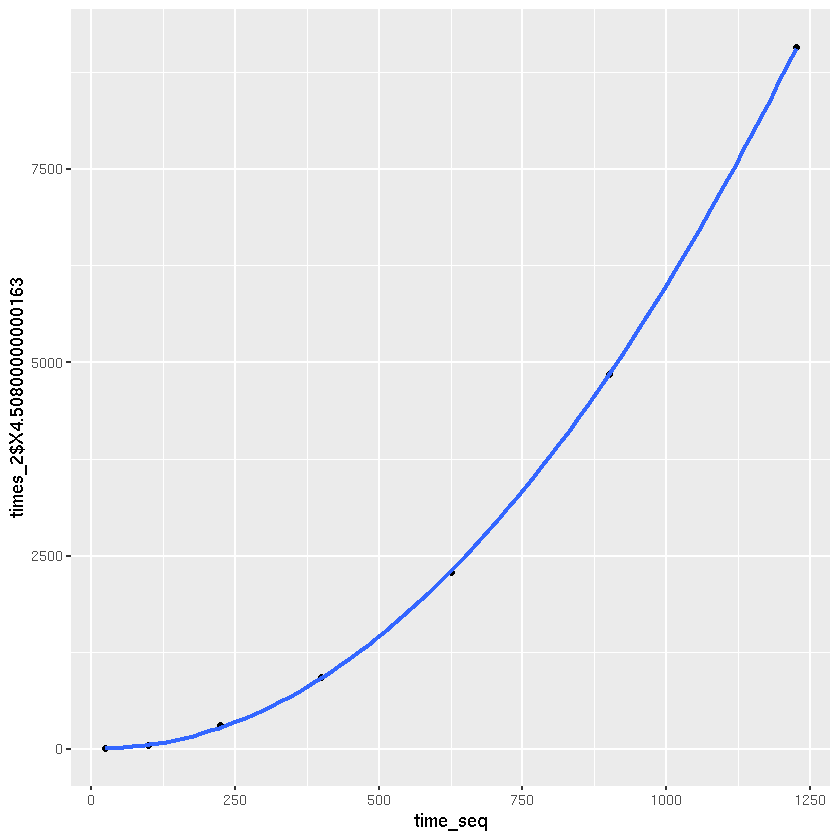

In [491]:
ggplot()+
geom_point(aes(x=time_seq,y=times_2$X4.50800000000163))+
geom_smooth(method="lm",aes(x=time_seq,y=times_2$X4.50800000000163),formula = y~poly(x,2))

In [493]:
predictor_time=lm(times_2$X4.50800000000163~poly(time_seq,2))
summary(predictor_time)


Call:
lm(formula = times_2$X4.50800000000163 ~ poly(time_seq, 2))

Residuals:
       1        2        3        4        5        6        7 
 -9.8867  -8.9461  30.6813   0.2033 -14.3104  -1.0289   3.2875 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2499.923      6.907   361.9 3.50e-10 ***
poly(time_seq, 2)1 7944.398     18.274   434.7 1.68e-10 ***
poly(time_seq, 2)2 2263.235     18.274   123.8 2.55e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.27 on 4 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.022e+05 on 2 and 4 DF,  p-value: 3.832e-10


# Visualizing the KNN

## Creating a grid

In [43]:
iris_grid=expand_grid(Sepal.Length = seq(min(iris$Sepal.Length),max(iris$Sepal.Length),0.05), Sepal.Width=seq(min(iris$Sepal.Width),max(iris$Sepal.Width),0.05))

In [44]:
iris_grid=data.frame(names=seq(1:nrow(iris_grid)),iris_grid,Species="unknown")

In [45]:
head(iris_grid)
dim(iris_grid)

,names,Sepal.Length,Sepal.Width,Species
,<int>,<dbl>,<dbl>,<chr>
1,1,4.3,2.00,unknown
2,2,4.3,2.05,unknown
3,3,4.3,2.10,unknown
4,4,4.3,2.15,unknown
5,5,4.3,2.20,unknown
6,6,4.3,2.25,unknown


[1] 3577    4

## Preparing the Iris dataset

In [50]:
iris=cbind(seq(1:nrow(iris)),datasets::iris)

In [51]:
colnames(iris)[1]="names"

In [52]:
head(iris[,c(1,2,3,6)])

,names,Sepal.Length,Sepal.Width,Species
,<int>,<dbl>,<dbl>,<fct>
1,1,5.1,3.5,setosa
2,2,4.9,3.0,setosa
3,3,4.7,3.2,setosa
4,4,4.6,3.1,setosa
5,5,5.0,3.6,setosa
6,6,5.4,3.9,setosa


## K=sqrt(length)

In [63]:
sqrt(length(iris))

[1] 2.44949

In [53]:
knn_iris=
knn(
  k=sqrt(length(iris)),
  train_data = iris[,c(1,2,3,6)],
  test_data = iris_grid,
  ncores = 80,
  outcome_var = "Species",
  name_var = "names",
  mode="prediction",
  sparsity_prp=1,
  scale=T
)

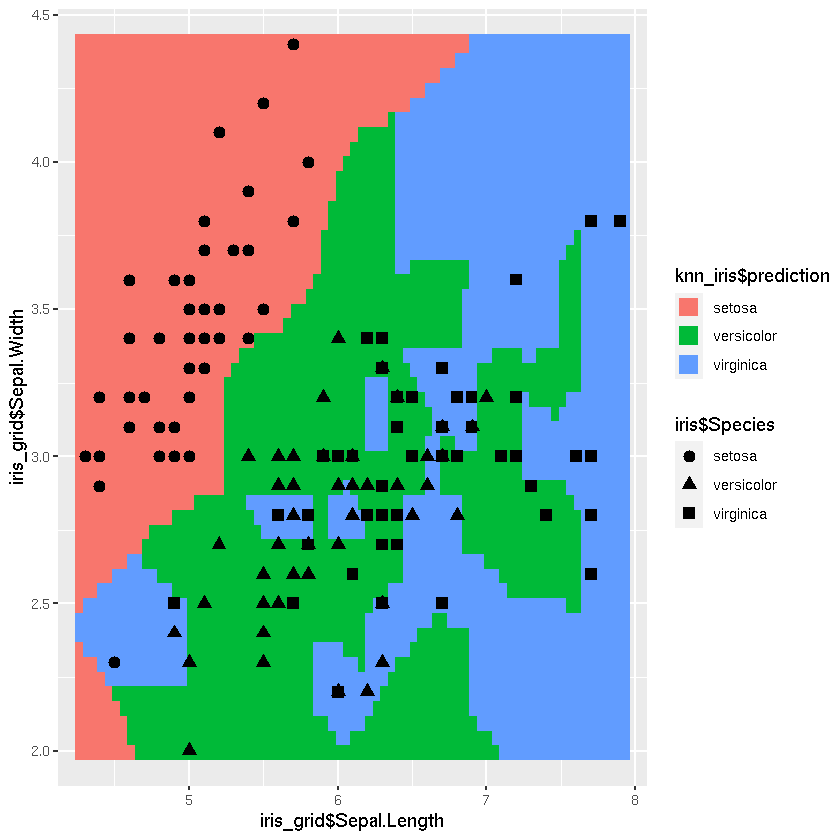

In [56]:
ggplot()+geom_point(aes(x=iris_grid$Sepal.Length,iris_grid$Sepal.Width,colour=knn_iris$prediction),size=5,pch=15)+geom_point(aes(x=iris$Sepal.Length,iris$Sepal.Width,pch=iris$Species),size=3)

## K=10

In [64]:
knn_iris=
knn(
  k=10,
  train_data = iris[,c(1,2,3,6)],
  test_data = iris_grid,
  ncores = 80,
  outcome_var = "Species",
  name_var = "names",
  mode="prediction",
  sparsity_prp=1,
  scale=T
)

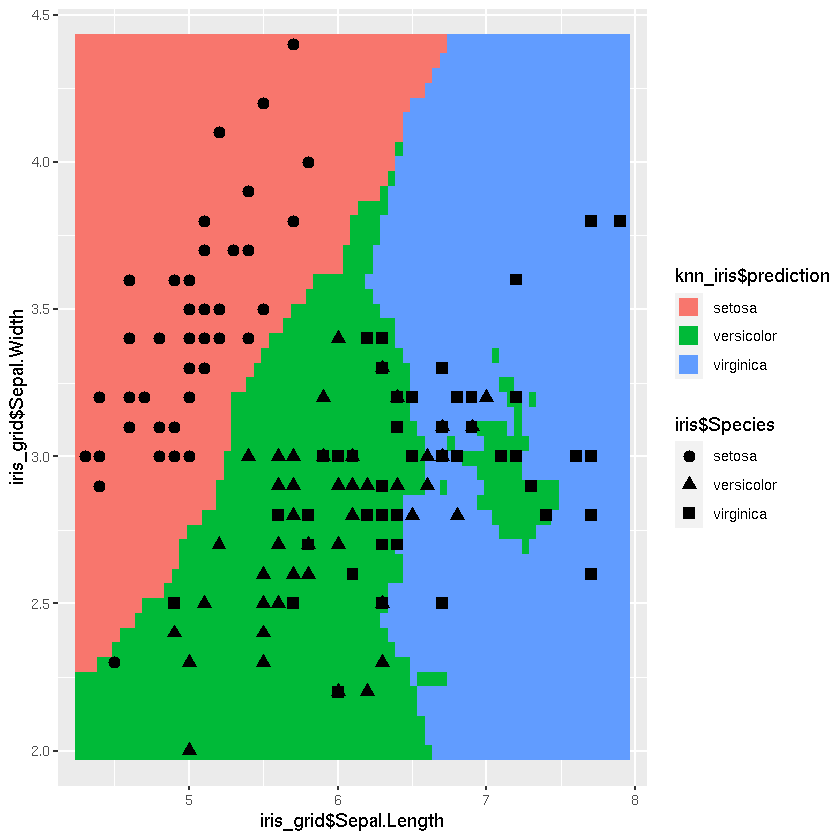

In [66]:
ggplot()+geom_point(aes(x=iris_grid$Sepal.Length,iris_grid$Sepal.Width,colour=knn_iris$prediction),size=5,pch=15)+geom_point(aes(x=iris$Sepal.Length,iris$Sepal.Width,pch=iris$Species),size=3)